# Visual Comparison of Transformer, OR-Tools,Christofides Results

In [75]:
import torch
import torch.nn as nn
import time
import argparse

import numpy as np
import pandas as pd

import os
import datetime

from torch.distributions.categorical import Categorical

# visualization 
%matplotlib inline
from IPython.display import set_matplotlib_formats, clear_output
set_matplotlib_formats('png2x','pdf')

import networkx as nx
from scipy.spatial.distance import pdist, squareform

from scipy.spatial import distance_matrix
from scipy.spatial.distance import cdist

# 导入ortool 组件
from __future__ import print_function
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
from munkres import Munkres

import copy
import itertools
from operator import itemgetter


C:\Users\Pengji Jin\AppData\Local\Temp\ipykernel_19944\579360858.py:17: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png2x','pdf')


CPU/GPU

In [76]:
device = torch.device("cpu"); gpu_id = -1 # select CPU

gpu_id = '0' # select a single GPU  
#gpu_id = '2,3' # select multiple GPUs  
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)  
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU name: {:s}, gpu_id: {:s}'.format(torch.cuda.get_device_name(0),gpu_id))   
    
print(device)


GPU name: NVIDIA GeForce RTX 3070 Ti Laptop GPU, gpu_id: 0
cuda


超参数设定
Hyper-parameters

In [77]:
class DotDict(dict):
    def __init__(self, **kwds):
        self.update(kwds)
        self.__dict__ = self
        
args = DotDict()
# args.nb_nodes = 20 # TSP20
args.nb_nodes = 50 # TSP50
#args.nb_nodes = 100 # TSP100
args.bsz = 512 # TSP20 TSP50
args.dim_emb = 128
args.dim_ff = 512
args.dim_input_nodes = 2
args.nb_layers_encoder = 6
args.nb_layers_decoder = 2
args.nb_heads = 8
args.nb_epochs = 10000
args.nb_batch_per_epoch = 2500
args.nb_batch_eval = 20
args.gpu_id = gpu_id
args.lr = 1e-4
args.tol = 1e-3
args.batchnorm = True  # if batchnorm=True  than batch norm is used
#args.batchnorm = False # if batchnorm=False than layer norm is used
args.max_len_PE = 1000

print(args)

{'nb_nodes': 50, 'bsz': 512, 'dim_emb': 128, 'dim_ff': 512, 'dim_input_nodes': 2, 'nb_layers_encoder': 6, 'nb_layers_decoder': 2, 'nb_heads': 8, 'nb_epochs': 10000, 'nb_batch_per_epoch': 2500, 'nb_batch_eval': 20, 'gpu_id': '0', 'lr': 0.0001, 'tol': 0.001, 'batchnorm': True, 'max_len_PE': 1000}


路径长度计算函数compute tour length

In [78]:
def compute_tour_length(x, tour): 
    """
    Compute the length of a batch of tours
    Inputs : x of size (bsz, nb_nodes, 2) batch of tsp tour instances
             tour of size (bsz, nb_nodes) batch of sequences (node indices) of tsp tours
    Output : L of size (bsz,)             batch of lengths of each tsp tour
    """
    # x 是一个形状为 (bsz, nb_nodes, 2) 的张量，表示一批TSP实例的城市坐标，其中bsz是批次大小（即有多少个独立的TSP实例），nb_nodes是每个TSP实例中的节点（城市）数量，最后的2代表每个节点的二维坐标。
    # tour 是一个形状为 (bsz, nb_nodes) 的张量，表示一批访问顺序（路径）。每个元素是一个整数，指示了访问城市（节点）的索引。
    bsz = x.shape[0]
    nb_nodes = x.shape[1]#从输入张量x中获取批次大小和节点数量
    # 创建一个从0到bsz-1的整数张量，用于索引批次中的每一个TSP实例。device=x.device确保这个张量在与x相同的设备（CPU或GPU）上创建。
    # 相当于索引了每个批
    arange_vec = torch.arange(bsz, device=x.device)
    # 冒号 : 表示选择所有元素。在第一个维度（行），冒号意味着选取所有的行。
    # 数字 0 表示选择第二维度（列）中的第0个元素，即第一列。
    # 结合起来，tour[:,0] 的意思是从名为 tour 的二维张量中选择每一行的第一个元素
    first_cities = x[arange_vec, tour[:,0], :] # size(first_cities)=(bsz,2)获取第一个坐标
    previous_cities = first_cities # 存储第一个城市坐标作为上一个城市计算
    # 初始化一个全零张量L，其大小为bsz，用来累积每个路径的总长度
    L = torch.zeros(bsz, device=x.device)

    # 遍历tour里每个元素，作为current，计算与previous的距离，再将current的存储为previous
    with torch.no_grad():
        for i in range(1,nb_nodes):
            current_cities = x[arange_vec, tour[:,i], :] 
            L += torch.sum( (current_cities - previous_cities)**2 , dim=1 )**0.5 # dist(current, previous node) 
            previous_cities = current_cities
        L += torch.sum( (current_cities - first_cities)**2 , dim=1 )**0.5 # dist(last, first node)  
    return L 

# 神经网络部分Transformer Part

定义神经网络Network definition

In [79]:
###################
#            bsz : batch size
#            nb_nodes : number of nodes/cities
#            dim_emb : embedding/hidden dimension
#            nb_heads : nb of attention heads
#            dim_ff : feed-forward dimension
#            nb_layers : number of encoder/decoder layers
###################

class Transformer_encoder_net(nn.Module):
    """
    Encoder network based on self-attention transformer
    Inputs :  
      h of size      (bsz, nb_nodes+1, dim_emb)    batch of input cities
    Outputs :  
      h of size      (bsz, nb_nodes+1, dim_emb)    batch of encoded cities
      score of size  (bsz, nb_nodes+1, nb_nodes+1) batch of attention scores
    """
    def __init__(self, nb_layers, dim_emb, nb_heads, dim_ff, batchnorm):
        super(Transformer_encoder_net, self).__init__()
        assert dim_emb == nb_heads* (dim_emb//nb_heads) # check if dim_emb is divisible by nb_heads
        self.MHA_layers = nn.ModuleList( [nn.MultiheadAttention(dim_emb, nb_heads) for _ in range(nb_layers)] )
        self.linear1_layers = nn.ModuleList( [nn.Linear(dim_emb, dim_ff) for _ in range(nb_layers)] )
        self.linear2_layers = nn.ModuleList( [nn.Linear(dim_ff, dim_emb) for _ in range(nb_layers)] )   
        if batchnorm:
            self.norm1_layers = nn.ModuleList( [nn.BatchNorm1d(dim_emb) for _ in range(nb_layers)] )
            self.norm2_layers = nn.ModuleList( [nn.BatchNorm1d(dim_emb) for _ in range(nb_layers)] )
        else:
            self.norm1_layers = nn.ModuleList( [nn.LayerNorm(dim_emb) for _ in range(nb_layers)] )
            self.norm2_layers = nn.ModuleList( [nn.LayerNorm(dim_emb) for _ in range(nb_layers)] )
        self.nb_layers = nb_layers
        self.nb_heads = nb_heads
        self.batchnorm = batchnorm
        
    def forward(self, h):      
        # PyTorch nn.MultiheadAttention requires input size (seq_len, bsz, dim_emb) 
        h = h.transpose(0,1) # size(h)=(nb_nodes, bsz, dim_emb)  
        # L layers
        for i in range(self.nb_layers):
            h_rc = h # residual connection, size(h_rc)=(nb_nodes, bsz, dim_emb)
            h, score = self.MHA_layers[i](h, h, h) # size(h)=(nb_nodes, bsz, dim_emb), size(score)=(bsz, nb_nodes, nb_nodes)
            # add residual connection
            h = h_rc + h # size(h)=(nb_nodes, bsz, dim_emb)
            if self.batchnorm:
                # Pytorch nn.BatchNorm1d requires input size (bsz, dim, seq_len)
                h = h.permute(1,2,0).contiguous() # size(h)=(bsz, dim_emb, nb_nodes)
                h = self.norm1_layers[i](h)       # size(h)=(bsz, dim_emb, nb_nodes)
                h = h.permute(2,0,1).contiguous() # size(h)=(nb_nodes, bsz, dim_emb)
            else:
                h = self.norm1_layers[i](h)       # size(h)=(nb_nodes, bsz, dim_emb) 
            # feedforward
            h_rc = h # residual connection
            h = self.linear2_layers[i](torch.relu(self.linear1_layers[i](h)))
            h = h_rc + h # size(h)=(nb_nodes, bsz, dim_emb)
            if self.batchnorm:
                h = h.permute(1,2,0).contiguous() # size(h)=(bsz, dim_emb, nb_nodes)
                h = self.norm2_layers[i](h)       # size(h)=(bsz, dim_emb, nb_nodes)
                h = h.permute(2,0,1).contiguous() # size(h)=(nb_nodes, bsz, dim_emb)
            else:
                h = self.norm2_layers[i](h) # size(h)=(nb_nodes, bsz, dim_emb)
        # Transpose h
        h = h.transpose(0,1) # size(h)=(bsz, nb_nodes, dim_emb)
        return h, score
    

def myMHA(Q, K, V, nb_heads, mask=None, clip_value=None):
    """
    Compute multi-head attention (MHA) given a query Q, key K, value V and attention mask :
      h = Concat_{k=1}^nb_heads softmax(Q_k^T.K_k).V_k 
    Note : We did not use nn.MultiheadAttention to avoid re-computing all linear transformations at each call.
    Inputs : Q of size (bsz, dim_emb, 1)                batch of queries
             K of size (bsz, dim_emb, nb_nodes+1)       batch of keys
             V of size (bsz, dim_emb, nb_nodes+1)       batch of values
             mask of size (bsz, nb_nodes+1)             batch of masks of visited cities
             clip_value is a scalar 
    Outputs : attn_output of size (bsz, 1, dim_emb)     batch of attention vectors
              attn_weights of size (bsz, 1, nb_nodes+1) batch of attention weights
    """
    bsz, nb_nodes, emd_dim = K.size() #  dim_emb must be divisable by nb_heads
    if nb_heads>1:
        # PyTorch view requires contiguous dimensions for correct reshaping
        Q = Q.transpose(1,2).contiguous() # size(Q)=(bsz, dim_emb, 1)
        Q = Q.view(bsz*nb_heads, emd_dim//nb_heads, 1) # size(Q)=(bsz*nb_heads, dim_emb//nb_heads, 1)
        Q = Q.transpose(1,2).contiguous() # size(Q)=(bsz*nb_heads, 1, dim_emb//nb_heads)
        K = K.transpose(1,2).contiguous() # size(K)=(bsz, dim_emb, nb_nodes+1)
        K = K.view(bsz*nb_heads, emd_dim//nb_heads, nb_nodes) # size(K)=(bsz*nb_heads, dim_emb//nb_heads, nb_nodes+1)
        K = K.transpose(1,2).contiguous() # size(K)=(bsz*nb_heads, nb_nodes+1, dim_emb//nb_heads)
        V = V.transpose(1,2).contiguous() # size(V)=(bsz, dim_emb, nb_nodes+1)
        V = V.view(bsz*nb_heads, emd_dim//nb_heads, nb_nodes) # size(V)=(bsz*nb_heads, dim_emb//nb_heads, nb_nodes+1)
        V = V.transpose(1,2).contiguous() # size(V)=(bsz*nb_heads, nb_nodes+1, dim_emb//nb_heads)
    attn_weights = torch.bmm(Q, K.transpose(1,2))/ Q.size(-1)**0.5 # size(attn_weights)=(bsz*nb_heads, 1, nb_nodes+1)
    if clip_value is not None:
        attn_weights = clip_value * torch.tanh(attn_weights)
    if mask is not None:
        if nb_heads>1:
            mask = torch.repeat_interleave(mask, repeats=nb_heads, dim=0) # size(mask)=(bsz*nb_heads, nb_nodes+1)
        #attn_weights = attn_weights.masked_fill(mask.unsqueeze(1), float('-inf')) # size(attn_weights)=(bsz*nb_heads, 1, nb_nodes+1)
        attn_weights = attn_weights.masked_fill(mask.unsqueeze(1), float('-1e9')) # size(attn_weights)=(bsz*nb_heads, 1, nb_nodes+1)
    attn_weights = torch.softmax(attn_weights, dim=-1) # size(attn_weights)=(bsz*nb_heads, 1, nb_nodes+1)
    attn_output = torch.bmm(attn_weights, V) # size(attn_output)=(bsz*nb_heads, 1, dim_emb//nb_heads)
    if nb_heads>1:
        attn_output = attn_output.transpose(1,2).contiguous() # size(attn_output)=(bsz*nb_heads, dim_emb//nb_heads, 1)
        attn_output = attn_output.view(bsz, emd_dim, 1) # size(attn_output)=(bsz, dim_emb, 1)
        attn_output = attn_output.transpose(1,2).contiguous() # size(attn_output)=(bsz, 1, dim_emb)
        attn_weights = attn_weights.view(bsz, nb_heads, 1, nb_nodes) # size(attn_weights)=(bsz, nb_heads, 1, nb_nodes+1)
        attn_weights = attn_weights.mean(dim=1) # mean over the heads, size(attn_weights)=(bsz, 1, nb_nodes+1)
    return attn_output, attn_weights
    
    
class AutoRegressiveDecoderLayer(nn.Module):
    """
    Single decoder layer based on self-attention and query-attention
    Inputs :  
      h_t of size      (bsz, 1, dim_emb)          batch of input queries
      K_att of size    (bsz, nb_nodes+1, dim_emb) batch of query-attention keys
      V_att of size    (bsz, nb_nodes+1, dim_emb) batch of query-attention values
      mask of size     (bsz, nb_nodes+1)          batch of masks of visited cities
    Output :  
      h_t of size (bsz, nb_nodes+1)               batch of transformed queries
    """
    def __init__(self, dim_emb, nb_heads):
        super(AutoRegressiveDecoderLayer, self).__init__()
        self.dim_emb = dim_emb
        self.nb_heads = nb_heads
        self.Wq_selfatt = nn.Linear(dim_emb, dim_emb)
        self.Wk_selfatt = nn.Linear(dim_emb, dim_emb)
        self.Wv_selfatt = nn.Linear(dim_emb, dim_emb)
        self.W0_selfatt = nn.Linear(dim_emb, dim_emb)
        self.W0_att = nn.Linear(dim_emb, dim_emb)
        self.Wq_att = nn.Linear(dim_emb, dim_emb)
        self.W1_MLP = nn.Linear(dim_emb, dim_emb)
        self.W2_MLP = nn.Linear(dim_emb, dim_emb)
        self.BN_selfatt = nn.LayerNorm(dim_emb)
        self.BN_att = nn.LayerNorm(dim_emb)
        self.BN_MLP = nn.LayerNorm(dim_emb)
        self.K_sa = None
        self.V_sa = None

    def reset_selfatt_keys_values(self):
        self.K_sa = None
        self.V_sa = None
        
    # For beam search
    def reorder_selfatt_keys_values(self, t, idx_top_beams):
        bsz, B = idx_top_beams.size()
        zero_to_B = torch.arange(B, device=idx_top_beams.device) # [0,1,...,B-1]
        B2 = self.K_sa.size(0)// bsz
        self.K_sa = self.K_sa.view(bsz, B2, t+1, self.dim_emb) # size(self.K_sa)=(bsz, B2, t+1, dim_emb)
        K_sa_tmp = self.K_sa.clone()
        self.K_sa = torch.zeros(bsz, B, t+1, self.dim_emb, device=idx_top_beams.device)
        for b in range(bsz):
            self.K_sa[b, zero_to_B, :, :] = K_sa_tmp[b, idx_top_beams[b], :, :]
        self.K_sa = self.K_sa.view(bsz*B, t+1, self.dim_emb) # size(self.K_sa)=(bsz*B, t+1, dim_emb)
        self.V_sa = self.V_sa.view(bsz, B2, t+1, self.dim_emb) # size(self.K_sa)=(bsz, B, t+1, dim_emb)
        V_sa_tmp = self.V_sa.clone()
        self.V_sa = torch.zeros(bsz, B, t+1, self.dim_emb, device=idx_top_beams.device)
        for b in range(bsz):
            self.V_sa[b, zero_to_B, :, :] = V_sa_tmp[b, idx_top_beams[b], :, :]
        self.V_sa = self.V_sa.view(bsz*B, t+1, self.dim_emb) # size(self.K_sa)=(bsz*B, t+1, dim_emb)

    # For beam search
    def repeat_selfatt_keys_values(self, B):
        self.K_sa = torch.repeat_interleave(self.K_sa, B, dim=0) # size(self.K_sa)=(bsz.B, t+1, dim_emb)
        self.V_sa = torch.repeat_interleave(self.V_sa, B, dim=0) # size(self.K_sa)=(bsz.B, t+1, dim_emb)
        
    def forward(self, h_t, K_att, V_att, mask):
        bsz = h_t.size(0)
        h_t = h_t.view(bsz,1,self.dim_emb) # size(h_t)=(bsz, 1, dim_emb)
        # embed the query for self-attention
        q_sa = self.Wq_selfatt(h_t) # size(q_sa)=(bsz, 1, dim_emb)
        k_sa = self.Wk_selfatt(h_t) # size(k_sa)=(bsz, 1, dim_emb)
        v_sa = self.Wv_selfatt(h_t) # size(v_sa)=(bsz, 1, dim_emb)
        # concatenate the new self-attention key and value to the previous keys and values
        if self.K_sa is None:
            self.K_sa = k_sa # size(self.K_sa)=(bsz, 1, dim_emb)
            self.V_sa = v_sa # size(self.V_sa)=(bsz, 1, dim_emb)
        else:
            self.K_sa = torch.cat([self.K_sa, k_sa], dim=1)
            self.V_sa = torch.cat([self.V_sa, v_sa], dim=1)
        # compute self-attention between nodes in the partial tour
        h_t = h_t + self.W0_selfatt( myMHA(q_sa, self.K_sa, self.V_sa, self.nb_heads)[0] ) # size(h_t)=(bsz, 1, dim_emb)
        h_t = self.BN_selfatt(h_t.squeeze()) # size(h_t)=(bsz, dim_emb)
        h_t = h_t.view(bsz, 1, self.dim_emb) # size(h_t)=(bsz, 1, dim_emb)
        # compute attention between self-attention nodes and encoding nodes in the partial tour (translation process)
        q_a = self.Wq_att(h_t) # size(q_a)=(bsz, 1, dim_emb)
        h_t = h_t + self.W0_att( myMHA(q_a, K_att, V_att, self.nb_heads, mask)[0] ) # size(h_t)=(bsz, 1, dim_emb)
        h_t = self.BN_att(h_t.squeeze()) # size(h_t)=(bsz, dim_emb)
        h_t = h_t.view(bsz, 1, self.dim_emb) # size(h_t)=(bsz, 1, dim_emb)
        # MLP
        h_t = h_t + self.W2_MLP(torch.relu(self.W1_MLP(h_t)))
        h_t = self.BN_MLP(h_t.squeeze(1)) # size(h_t)=(bsz, dim_emb)
        return h_t
        
        
class Transformer_decoder_net(nn.Module): 
    """
    Decoder network based on self-attention and query-attention transformers
    Inputs :  
      h_t of size      (bsz, 1, dim_emb)                            batch of input queries
      K_att of size    (bsz, nb_nodes+1, dim_emb*nb_layers_decoder) batch of query-attention keys for all decoding layers
      V_att of size    (bsz, nb_nodes+1, dim_emb*nb_layers_decoder) batch of query-attention values for all decoding layers
      mask of size     (bsz, nb_nodes+1)                            batch of masks of visited cities
    Output :  
      prob_next_node of size (bsz, nb_nodes+1)                      batch of probabilities of next node
    """
    def __init__(self, dim_emb, nb_heads, nb_layers_decoder):
        super(Transformer_decoder_net, self).__init__()
        self.dim_emb = dim_emb
        self.nb_heads = nb_heads
        self.nb_layers_decoder = nb_layers_decoder
        self.decoder_layers = nn.ModuleList( [AutoRegressiveDecoderLayer(dim_emb, nb_heads) for _ in range(nb_layers_decoder-1)] )
        self.Wq_final = nn.Linear(dim_emb, dim_emb)
        
    # Reset to None self-attention keys and values when decoding starts 
    def reset_selfatt_keys_values(self): 
        for l in range(self.nb_layers_decoder-1):
            self.decoder_layers[l].reset_selfatt_keys_values()
            
    # For beam search
    def reorder_selfatt_keys_values(self, t, idx_top_beams):
        for l in range(self.nb_layers_decoder-1):
            self.decoder_layers[l].reorder_selfatt_keys_values(t, idx_top_beams)
    
    # For beam search
    def repeat_selfatt_keys_values(self, B):
        for l in range(self.nb_layers_decoder-1):
            self.decoder_layers[l].repeat_selfatt_keys_values(B)
     
    def forward(self, h_t, K_att, V_att, mask):
        for l in range(self.nb_layers_decoder):
            K_att_l = K_att[:,:,l*self.dim_emb:(l+1)*self.dim_emb].contiguous()  # size(K_att_l)=(bsz, nb_nodes+1, dim_emb)
            V_att_l = V_att[:,:,l*self.dim_emb:(l+1)*self.dim_emb].contiguous()  # size(V_att_l)=(bsz, nb_nodes+1, dim_emb)
            if l<self.nb_layers_decoder-1: # decoder layers with multiple heads (intermediate layers)
                h_t = self.decoder_layers[l](h_t, K_att_l, V_att_l, mask)
            else: # decoder layers with single head (final layer)
                q_final = self.Wq_final(h_t)
                bsz = h_t.size(0)
                q_final = q_final.view(bsz, 1, self.dim_emb)
                attn_weights = myMHA(q_final, K_att_l, V_att_l, 1, mask, 10)[1] 
        prob_next_node = attn_weights.squeeze(1) 
        return prob_next_node


def generate_positional_encoding(d_model, max_len):
    """
    Create standard transformer PEs.
    Inputs :  
      d_model is a scalar correspoding to the hidden dimension
      max_len is the maximum length of the sequence
    Output :  
      pe of size (max_len, d_model), where d_model=dim_emb, max_len=1000
    """
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
    pe[:,0::2] = torch.sin(position * div_term)
    pe[:,1::2] = torch.cos(position * div_term)
    return pe
    
    
class TSP_net(nn.Module): 
    """
    The TSP network is composed of two steps :
      Step 1. Encoder step : Take a set of 2D points representing a fully connected graph 
                             and encode the set with self-transformer.
      Step 2. Decoder step : Build the TSP tour recursively/autoregressively, 
                             i.e. one node at a time, with a self-transformer and query-transformer. 
    Inputs : 
      x of size (bsz, nb_nodes, dim_emb) Euclidian coordinates of the nodes/cities
      deterministic is a boolean : If True the salesman will chose the city with highest probability. 
                                   If False the salesman will chose the city with Bernouilli sampling.
    Outputs : 
      tours of size (bsz, nb_nodes) : batch of tours, i.e. sequences of ordered cities 
                                      tours[b,t] contains the idx of the city visited at step t in batch b
      sumLogProbOfActions of size (bsz,) : batch of sum_t log prob( pi_t | pi_(t-1),...,pi_0 )
    """
    
    def __init__(self, dim_input_nodes, dim_emb, dim_ff, nb_layers_encoder, nb_layers_decoder, nb_heads, max_len_PE,
                 batchnorm=True):
        super(TSP_net, self).__init__()
        
        self.dim_emb = dim_emb
        
        # input embedding layer
        self.input_emb = nn.Linear(dim_input_nodes, dim_emb)
        
        # encoder layer
        self.encoder = Transformer_encoder_net(nb_layers_encoder, dim_emb, nb_heads, dim_ff, batchnorm)
        
        # vector to start decoding 
        self.start_placeholder = nn.Parameter(torch.randn(dim_emb))
        
        # decoder layer
        self.decoder = Transformer_decoder_net(dim_emb, nb_heads, nb_layers_decoder)
        self.WK_att_decoder = nn.Linear(dim_emb, nb_layers_decoder* dim_emb) 
        self.WV_att_decoder = nn.Linear(dim_emb, nb_layers_decoder* dim_emb) 
        self.PE = generate_positional_encoding(dim_emb, max_len_PE)        
        
    def forward(self, x, B, greedy, beamsearch):
        
        # some parameters
        bsz = x.shape[0]
        nb_nodes = x.shape[1]
        zero_to_bsz = torch.arange(bsz, device=x.device) # [0,1,...,bsz-1]
        
        # For beam search
        zero_to_B = torch.arange(B, device=x.device) # [0,1,...,B-1]

        # input embedding layer
        h = self.input_emb(x) # size(h)=(bsz, nb_nodes, dim_emb)
        
        # concat the nodes and the input placeholder that starts the decoding
        h = torch.cat([h, self.start_placeholder.repeat(bsz, 1, 1)], dim=1) # size(start_placeholder)=(bsz, nb_nodes+1, dim_emb)
        
        # encoder layer
        h_encoder, _ = self.encoder(h) # size(h)=(bsz, nb_nodes+1, dim_emb)

        # key and value for decoder    
        K_att_decoder = self.WK_att_decoder(h_encoder) # size(K_att)=(bsz, nb_nodes+1, dim_emb*nb_layers_decoder)
        V_att_decoder = self.WV_att_decoder(h_encoder) # size(V_att)=(bsz, nb_nodes+1, dim_emb*nb_layers_decoder)
        
        # starting node in tour
        self.PE = self.PE.to(x.device)
        
        # For beam search
        tours_greedy = torch.zeros(2, nb_nodes, device=x.device)
        tours_beamsearch = torch.zeros(2, nb_nodes, device=x.device)
        scores_greedy = torch.zeros(2, device=x.device)
        scores_beamsearch = torch.zeros(2, device=x.device)
        
        # Greedy search
        if greedy:
            #print('Greedy decoding')
            deterministic = True
            # list that will contain Long tensors of shape (bsz,) that gives the idx of the cities chosen at time t
            tours = []
            # list that will contain Float tensors of shape (bsz,) that gives the neg log probs of the choices made at time t
            sumLogProbOfActions = []
            # input placeholder that starts the decoding
            idx_start_placeholder = torch.Tensor([nb_nodes]).long().repeat(bsz).to(x.device)
            h_start = h_encoder[zero_to_bsz, idx_start_placeholder, :] + self.PE[0].repeat(bsz,1) # size(h_start)=(bsz, dim_emb)
            # initialize mask of visited cities
            mask_visited_nodes = torch.zeros(bsz, nb_nodes+1, device=x.device).bool() # False
            mask_visited_nodes[zero_to_bsz, idx_start_placeholder] = True
            # clear key and val stored in the decoder
            self.decoder.reset_selfatt_keys_values()
            # construct tour recursively
            h_t = h_start
            for t in range(nb_nodes):
                # compute probability over the next node in the tour
                prob_next_node = self.decoder(h_t, K_att_decoder, V_att_decoder, mask_visited_nodes) # size(prob_next_node)=(bsz, nb_nodes+1)
                # choose node with highest probability or sample with Bernouilli 
                if deterministic:
                    idx = torch.argmax(prob_next_node, dim=1) # size(query)=(bsz,)
                else:
                    idx = Categorical(prob_next_node).sample() # size(query)=(bsz,)
                # compute logprobs of the action items in the list sumLogProbOfActions   
                ProbOfChoices = prob_next_node[zero_to_bsz, idx] 
                sumLogProbOfActions.append( torch.log(ProbOfChoices) )  # size(query)=(bsz,)
                # update embedding of the current visited node
                h_t = h_encoder[zero_to_bsz, idx, :] # size(h_start)=(bsz, dim_emb)
                h_t = h_t + self.PE[t+1].expand(bsz, self.dim_emb)
                # update tour
                tours.append(idx)
                # update masks with visited nodes
                mask_visited_nodes = mask_visited_nodes.clone()
                mask_visited_nodes[zero_to_bsz, idx] = True
            # logprob_of_choices = sum_t log prob( pi_t | pi_(t-1),...,pi_0 )
            sumLogProbOfActions = torch.stack(sumLogProbOfActions,dim=1).sum(dim=1) # size(sumLogProbOfActions)=(bsz,)
            # convert the list of nodes into a tensor of shape (bsz,num_cities)
            tours = torch.stack(tours,dim=1) # size(col_index)=(bsz, nb_nodes)
            tours_greedy = tours
            scores_greedy = sumLogProbOfActions 
        
        # Beamsearch
        if beamsearch:
            #print('Beam search decoding')
            # clear key and val stored in the decoder
            self.decoder.reset_selfatt_keys_values() 
            K_att_decoder_tmp = K_att_decoder # size(K_att_decoder_tmp)=(bsz, nb_nodes, dim_emb*nb_layers_decoder)
            V_att_decoder_tmp = V_att_decoder # size(V_att_decoder_tmp)=(bsz, nb_nodes, dim_emb*nb_layers_decoder)
            for t in range(nb_nodes):
                #if not t%10:
                #    print('t: {}, GPU reserved mem: {:.2f}, GPU allocated mem: {:.2f}'.format(t,torch.cuda.memory_reserved(0)/1e9,torch.cuda.memory_allocated(0)/1e9))
                if t==0: # at t=0, there are at most B_{t=0}=nb_nodes beams
                    B_t0 = min(B, nb_nodes)
                    # input placeholder that starts the decoding
                    idx_start_placeholder = torch.Tensor([nb_nodes]).long().repeat(bsz).to(x.device)
                    h_start = h_encoder[zero_to_bsz, idx_start_placeholder, :] + self.PE[0].repeat(bsz,1) # size(h_start)=(bsz, dim_emb)
                    h_t = h_start # size(h_start)=(bsz, dim_emb)
                    mask_visited_nodes = torch.zeros(bsz, nb_nodes+1, device=x.device).bool() # False, size(mask_visited_nodes)=(bsz, nb_nodes+1) # initialize mask of visited cities
                    mask_visited_nodes[zero_to_bsz, idx_start_placeholder] = True
                    # compute probability over the next node in the tour
                    prob_next_node = self.decoder(h_t, K_att_decoder, V_att_decoder, mask_visited_nodes) # size(prob_next_node)=(bsz, nb_nodes+1) 
                    # compute score_t + sum_t score_{t-1} for all beams
                    score_t = torch.log(prob_next_node) # size(score_t)=(bsz, nb_nodes+1) for t=0 
                    sum_scores = score_t # size(score_t)=(bsz, nb_nodes+1)
                    # choose nodes with top-B sumScores 
                    top_val, top_idx = torch.topk(sum_scores, B_t0, dim=1) # size(sumScores)=(bsz, B_t0)
                    # update sum_t score_{t} for all beams
                    sum_scores = top_val # size(sumScores)=(bsz, B_t0) 
                    zero_to_B_t0 = torch.arange(B_t0, device=x.device) # [0,1,...,B_t0-1]
                    mask_visited_nodes = mask_visited_nodes.unsqueeze(1) # size(mask_visited_nodes)=(bsz, 1, nb_nodes+1)
                    mask_visited_nodes = torch.repeat_interleave(mask_visited_nodes, B_t0, dim=1)
                    for b in range(bsz):
                        mask_visited_nodes[b, zero_to_B_t0, top_idx[b]] = True # size(mask_visited_nodes)=(bsz, B_t0, nb_nodes+1)
                    tours = torch.zeros(bsz, B_t0, nb_nodes, device=x.device).long() # size(tours)=(bsz, B_t0, nb_nodes)
                    tours[:,:,t] = top_idx # size(tours)=(bsz, B_t0, nb_nodes)
                    # update embedding of the current visited node
                    h_t = torch.zeros(bsz, B_t0, self.dim_emb, device=x.device) # size(tours)=(bsz, B_t0, dim_emb)
                    for b in range(bsz):
                        h_t[b, :, :] = h_encoder[b, top_idx[b], :] # size(h_t)=(bsz, B_t0, dim_emb)
                    h_t = h_t + self.PE[t+1].expand(bsz, B_t0, self.dim_emb) # size(h_t)=(bsz, B_t0, dim_emb)
                    self.decoder.repeat_selfatt_keys_values(B_t0)
                    K_att_decoder = torch.repeat_interleave(K_att_decoder_tmp, B_t0, dim=0) # size(K_att_decoder)=(bsz*B_t0, nb_nodes+1, dim_emb*nb_layers_decoder)
                    V_att_decoder = torch.repeat_interleave(V_att_decoder_tmp, B_t0, dim=0) # size(V_att_decoder)=(bsz*B_t0, nb_nodes+1, dim_emb*nb_layers_decoder)
                    
                elif t==1: # at t=1, there are at most B_{t=1}=nb_nodes^2 beams
                    # compute probability over the next node in the tour
                    h_t = h_t.view(bsz*B_t0, self.dim_emb)
                    mask_visited_nodes = mask_visited_nodes.view(bsz*B_t0, nb_nodes+1)
                    prob_next_node = self.decoder(h_t, K_att_decoder, V_att_decoder, mask_visited_nodes) # size(prob_next_node)=(bsz.B_t0, nb_nodes+1) 
                    prob_next_node = prob_next_node.view(bsz, B_t0, nb_nodes+1) # size(prob_next_node)=(bsz, B_t0, nb_nodes+1) 
                    mask_visited_nodes = mask_visited_nodes.view(bsz, B_t0, nb_nodes+1)
                    h_t = h_t.view(bsz, B_t0, self.dim_emb) 
                    # compute score_t + sum_t score_{t-1} for all beams
                    score_t = torch.log(prob_next_node) # size(score_t)=(bsz, B, nb_nodes+1) 
                    sum_scores = score_t + sum_scores.unsqueeze(2) # size(score_t)=(bsz, B, nb_nodes+1)
                    sum_scores_flatten = sum_scores.view(bsz, -1) # size(sumScores_next_node)=(bsz, B.(nb_nodes+1))
                    # choose nodes with top-B sumScores 
                    top_val, top_idx = torch.topk(sum_scores_flatten, B, dim=1)
                    idx_top_beams = top_idx // (nb_nodes+1) # size(idx_beam_topB)=(bsz, B)
                    idx_in_beams = top_idx - idx_top_beams* (nb_nodes+1) # size(idx_in_beams)=(bsz, B)
                    # update sum_t score_{t} for all beams
                    sum_scores = top_val
                    # update beam masks with visited nodes
                    mask_visited_nodes_tmp = mask_visited_nodes.clone() # size(mask_visited_nodes_tmp)=(bsz, B_t0, nb_nodes+1)
                    mask_visited_nodes = torch.zeros(bsz, B, nb_nodes+1, device=x.device).bool() # size(mask_visited_nodes)=(bsz, B, nb_nodes+1)
                    for b in range(bsz):
                        mask_visited_nodes[b, zero_to_B, :] = mask_visited_nodes_tmp[b, idx_top_beams[b], :] # size(mask_visited_nodes)=(bsz, B, nb_nodes+1)
                    for b in range(bsz):
                        mask_visited_nodes[b, zero_to_B, idx_in_beams[b]] = True # size(mask_visited_nodes)=(bsz, B, nb_nodes+1)
                    # update beam tours with visited nodes
                    tours_tmp = tours.clone()
                    tours = torch.zeros(bsz, B, nb_nodes, device=x.device).long() # size(tours)=(bsz, B, nb_nodes)
                    for b in range(bsz):
                        tours[b, zero_to_B, :] = tours_tmp[b, idx_top_beams[b], :]
                    tours[:,:,t] = idx_in_beams # size(tours)=(bsz, B, nb_nodes)
                    # update embedding of the current visited node
                    h_t = torch.zeros(bsz, B, self.dim_emb, device=x.device) # size(tours)=(bsz, B_t0, dim_emb)
                    for b in range(bsz):
                        h_t[b, :, :] = h_encoder[b, idx_in_beams[b], :] # size(h_t)=(bsz, B, dim_emb)
                    h_t = h_t + self.PE[t+1].expand(bsz, B, self.dim_emb) # size(h_t)=(bsz, B, dim_emb)
                    # update self-attention embeddings of partial tours
                    self.decoder.reorder_selfatt_keys_values(t, idx_top_beams) # size(K_att_decoder)=(bsz*B_t0, nb_nodes+1, dim_emb*nb_layers_decoder)
                    K_att_decoder = torch.repeat_interleave(K_att_decoder_tmp, B, dim=0) # size(K_att_decoder)=(bsz*B, nb_nodes+1, dim_emb*nb_layers_decoder)
                    V_att_decoder = torch.repeat_interleave(V_att_decoder_tmp, B, dim=0) # size(V_att_decoder)=(bsz*B, nb_nodes+1, dim_emb*nb_layers_decoder)

                else: # at t>=2, we arbitrary decide to have at most B_{t>=2}=nb_nodes^2 beams
                    # compute probability over the next node in the tour
                    h_t = h_t.view(bsz*B, self.dim_emb)
                    mask_visited_nodes = mask_visited_nodes.view(bsz*B, nb_nodes+1)
                    prob_next_node = self.decoder(h_t, K_att_decoder, V_att_decoder, mask_visited_nodes) # size(prob_next_node)=(bsz.B, nb_nodes+1) 
                    prob_next_node = prob_next_node.view(bsz, B, nb_nodes+1) # size(prob_next_node)=(bsz, B, nb_nodes+1) 
                    mask_visited_nodes = mask_visited_nodes.view(bsz, B, nb_nodes+1)
                    h_t = h_t.view(bsz, B, self.dim_emb) 
                    # compute score_t + sum_t score_{t-1} for all beams
                    score_t = torch.log(prob_next_node) # size(score_t)=(bsz, B, nb_nodes+1)
                    sum_scores = score_t + sum_scores.unsqueeze(2) # size(score_t)=(bsz, B, nb_nodes+1)
                    sum_scores_flatten = sum_scores.view(bsz, -1) # size(sumScores_next_node)=(bsz, B.(nb_nodes+1))
                    # choose nodes with top-B sumScores 
                    top_val, top_idx = torch.topk(sum_scores_flatten, B, dim=1)
                    idx_top_beams = top_idx // (nb_nodes+1) # size(idx_beam_topB)=(bsz, B)
                    idx_in_beams = top_idx - idx_top_beams* (nb_nodes+1) # size(idx_in_beams)=(bsz, B)
                    # update sum_t score_{t} for all beams
                    sum_scores = top_val
                    # update beam masks with visited nodes
                    mask_visited_nodes_tmp = mask_visited_nodes.clone()
                    for b in range(bsz):
                        mask_visited_nodes[b, zero_to_B, :] = mask_visited_nodes_tmp[b, idx_top_beams[b], :]
                    for b in range(bsz):
                        mask_visited_nodes[b, zero_to_B, idx_in_beams[b]] = True
                    # update beam tours with visited nodes
                    tours_tmp = tours.clone()
                    for b in range(bsz):
                        tours[b, zero_to_B, :] = tours_tmp[b, idx_top_beams[b], :]
                    tours[:,:,t] = idx_in_beams # size(tours)=(bsz, B, nb_nodes)
                    # update embedding of the current visited node
                    for b in range(bsz):
                        h_t[b, :, :] = h_encoder[b, idx_in_beams[b], :] # size(h_t)=(bsz, B, dim_emb)
                    h_t = h_t + self.PE[t+1].expand(bsz, B, self.dim_emb) # size(h_t)=(bsz, B, dim_emb)
                    # update self-attention embeddings of partial tours
                    self.decoder.reorder_selfatt_keys_values(t, idx_top_beams)
            # sum_t log prob( pi_t | pi_0,...pi_(t-1) )
            sum_scores = sum_scores[:,0] # size(sumScores)=(bsz)
            tours_beamsearch = tours
            scores_beamsearch = sum_scores

        return tours_greedy, tours_beamsearch, scores_greedy, scores_beamsearch
    

初始化神经网络

In [80]:
###################
# Instantiate a training network and a baseline network
###################
try: 
    del model_baseline # remove existing model
except:
    pass

model_baseline = TSP_net(args.dim_input_nodes, args.dim_emb, args.dim_ff, 
              args.nb_layers_encoder, args.nb_layers_decoder, args.nb_heads, args.max_len_PE,
              batchnorm=args.batchnorm)

# # uncomment these lines if trained with multiple GPUs
# print(torch.cuda.device_count())
# if torch.cuda.device_count()>1:
#     model_baseline = nn.DataParallel(model_baseline)
# # uncomment these lines if trained with multiple GPUs

model_baseline = model_baseline.to(device)
model_baseline.eval()

print(args); print('')

{'nb_nodes': 50, 'bsz': 512, 'dim_emb': 128, 'dim_ff': 512, 'dim_input_nodes': 2, 'nb_layers_encoder': 6, 'nb_layers_decoder': 2, 'nb_heads': 8, 'nb_epochs': 10000, 'nb_batch_per_epoch': 2500, 'nb_batch_eval': 20, 'gpu_id': '0', 'lr': 0.0001, 'tol': 0.001, 'batchnorm': True, 'max_len_PE': 1000}



加载训练好的模型Load a Pre-trained Model

In [81]:
###################
# Load checkpoint
###################
#读取训练好的模型
checkpoint_file = "checkpoint/checkpoint_21-03-01--17-25-00-n50-gpu0.pkl" 
checkpoint = torch.load(checkpoint_file, map_location=device)
epoch_ckpt = checkpoint['epoch'] + 1
tot_time_ckpt = checkpoint['tot_time']
plot_performance_train = checkpoint['plot_performance_train']
plot_performance_baseline = checkpoint['plot_performance_baseline']
model_baseline.load_state_dict(checkpoint['model_baseline'])
print('Load checkpoint file={:s}\n  Checkpoint at epoch= {:d} and time={:.3f}min\n'.format(checkpoint_file,epoch_ckpt-1,tot_time_ckpt/60))
del checkpoint

mystring_min = 'Epoch: {:d}, tot_time_ckpt: {:.3f}day, L_train: {:.3f}, L_base: {:.3f}\n'.format(
    epoch_ckpt, tot_time_ckpt/3660/24, plot_performance_train[-1][1], plot_performance_baseline[-1][1]) 
print(mystring_min) 

Load checkpoint file=checkpoint/checkpoint_21-03-01--17-25-00-n50-gpu0.pkl
  Checkpoint at epoch= 1623 and time=30080.135min

Epoch: 1624, tot_time_ckpt: 20.547day, L_train: 5.707, L_base: 5.705



# ortool part

打印ortool解决方案print solution

In [82]:
def print_ortool_solution(manager, routing, solution):
    """Prints solution on console."""
    print("Objective: {}".format(solution.ObjectiveValue()))
    index = routing.Start(0)
    plan_output = "Route for vehicle 0:\n"
    route_distance = 0
    while not routing.IsEnd(index):
        plan_output += " {} ->".format(manager.IndexToNode(index))
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    plan_output += " {}\n".format(manager.IndexToNode(index))
    print(plan_output)
    plan_output += "Route distance: {}miles\n".format(route_distance)

获取ortool求解的路径get routes from ortool

In [83]:
# 定义一个名为get_routes的函数，它接收四个参数：
# manager: 路由索引管理器实例，帮助转换索引和节点。
# routing: 包含路由模型信息的对象。
# solution: 求解器找到的解决方案对象。
# nb_nodes: 每个TSP实例中最大节点数量，用于初始化输出张量的形状。
def get_routes(manager, routing, solution, nb_nodes):
    """Get vehicle routes from a solution and store them in a tensor of shape (bsz, nb_nodes)."""
    # 获取车辆数量
    bsz = routing.vehicles()
    
    # 初始化一个全零张量用于存储所有车辆的路径，假设路径长度为nb_nodes
    tour = torch.zeros((bsz, nb_nodes), dtype=torch.long)
    
    # 遍历每一个车辆
    for route_nbr in range(bsz):
        index = routing.Start(route_nbr)  # 起始位置索引
        node_index = 0  # 用于跟踪当前路径上的节点位置
        
        # 添加起始节点
        tour[route_nbr, node_index] = manager.IndexToNode(index)
        node_index += 1
        
        # 构建单个车辆的完整路径
        while not routing.IsEnd(index) and node_index < nb_nodes:
            index = solution.Value(routing.NextVar(index))
            tour[route_nbr, node_index] = manager.IndexToNode(index)
            node_index += 1
        
        # 如果路径较短，则剩余的位置保持为0（或可以用其他方式填充）
        if node_index < nb_nodes:
            tour[route_nbr, node_index:] = 0  # 或者根据需要填充特定值
    
    return tour

求解器优化部分,接下来要优化策略Solver Optimization

In [84]:
def optimize_routes(distance_matrix, depot, nb_nodes, print_solution_to_console=True):
    """Optimize routes and return them as a tensor of shape (bsz, nb_nodes)."""
    
    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(distance_matrix), 1, depot
    )  # num of vehicles set to 1
    
    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return distance_matrix[from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    if solution:
        # Call get_routes_as_tensor to return the result as a tensor.
        tour_tensor = get_routes(manager, routing, solution, nb_nodes)
        
        if print_solution_to_console:
            print_ortool_solution(manager, routing, solution)
        
        return tour_tensor
    else:
        print("No solution found.")
        return None

# Christofides

In [85]:
def compute_distance_matrix(nodes):
    """
    根据给定的城市坐标计算距离矩阵。
    
    参数:
        nodes: 一个形状为 (bsz, nb_nodes, 2) 的numpy数组，表示每个城市的二维坐标。
    
    返回:
        distance_matrix: 一个形状为 (bsz, nb_nodes, nb_nodes) 的numpy数组，其中每个元素代表两个城市之间的欧几里得距离。
    """
    bsz, num_nodes = nodes.shape[0], nodes.shape[1]
    distance_matrix = np.zeros((bsz, num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            dist = np.linalg.norm(nodes[:, i, :] - nodes[:, j, :], axis=-1)
            distance_matrix[:, i, j] = dist
            distance_matrix[:, j, i] = dist
    return distance_matrix

In [86]:
def christofides_tsp_batch(nodes):
    """
    使用Christofides算法解决旅行商问题(TSP)，支持批次数据。
    
    参数:
        nodes: 一个形状为 (bsz, nb_nodes, 2) 的numpy数组，表示每个城市的二维坐标。
    返回:
        tour: 一个形状为 (bsz, nb_nodes) 的numpy数组，表示访问所有城市的顺序。
    """
    bsz = nodes.shape[0]
    tours = []
    
    for batch_idx in range(bsz):
        node_coords = nodes[batch_idx]
        distance_matrix = compute_distance_matrix(node_coords[np.newaxis, :, :])[0]
        G = nx.from_numpy_array(distance_matrix)
        
        # 计算最小生成树
        MST = nx.minimum_spanning_tree(G)
        
        # 找到所有度数为奇数的节点
        odd_degree_nodes = [v for v, d in MST.degree() if d % 2 != 0]
        
        # 创建子图包含这些奇数度节点
        odd_node_subgraph = G.subgraph(odd_degree_nodes)
        
        # 计算最小权重匹配（通过取负权值实现）
        min_weight_matching = nx.algorithms.matching.min_weight_matching(odd_node_subgraph, maxcardinality=True)
        
        # 合并MST和最小权重匹配得到一个多重图
        multigraph = nx.MultiGraph(MST)
        multigraph.add_edges_from(min_weight_matching)
        
        # 在这个多重图中找到欧拉回路
        eulerian_circuit = list(nx.eulerian_circuit(multigraph))
        
        # 使用欧拉回路构造最终的TSP路径
        visited = set()
        tour = []
        for u, _ in eulerian_circuit:
            if u not in visited:
                tour.append(u)
                visited.add(u)
    
        # 添加起点以形成闭环
        tour.append(tour[0])
        tours.append(tour)
    
    return np.array(tours)

# 可视化Visualization

In [87]:
def plot_nodes(x_coord, route=None, batch_idx=0, route_distance=None, compute_tour_length_func=None, plot_dist_pair=False, ax=None):
    """
    Plot nodes and tours for a single batch.
    
    Parameters:
    - ax: Matplotlib axis object to draw on.
    - x_coord: A numpy array of shape (nb_nodes, 2) representing city coordinates.
    - route: A list or tensor of shape (nb_nodes,) representing the sequence of visited cities.
    - batch_idx: Index of the batch to plot.
    - route_distance: The total distance of the route.
    - compute_tour_length_func: Function to compute tour length if needed.
    - plot_dist_pair: Whether to plot all pairwise distances between nodes.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # Convert tensors to numpy arrays if necessary
    x_coord = x_coord.detach().cpu().numpy() if isinstance(x_coord, torch.Tensor) else x_coord
    if route is not None:
        route = route.detach().cpu().numpy() if isinstance(route, torch.Tensor) else route

    nb_nodes = x_coord.shape[0]
    G = nx.Graph()
    G.add_nodes_from(range(nb_nodes))
    
    pos_i = dict(zip(range(len(x_coord)), x_coord))

    # Draw nodes
    nx.draw_networkx_nodes(G, pos=pos_i, node_color=['g'] + ['b'] * (nb_nodes - 1), node_size=20, ax=ax)

    if route is not None:
        edges = [(route[r], route[(r + 1) % nb_nodes]) for r in range(nb_nodes)]
        nx.draw_networkx_edges(G, pos=pos_i, edgelist=edges, alpha=1, width=1, edge_color='r', ax=ax)
        
        if plot_dist_pair:
            dist_pair_i = squareform(pdist(x_coord, metric='euclidean'))
            G_dist = nx.from_numpy_matrix(dist_pair_i)
            nx.draw_networkx_edges(G_dist, pos=pos_i, alpha=0.3, width=0.5, ax=ax)
        
        title = f'Batch {batch_idx}, Route Length: {route_distance:.2f}' if route_distance is not None else f'Batch {batch_idx}'
        ax.set_title(title)

def plot_all_batches(nodes_tensor, routes_list, x, tour, ax=None):
    """
    Plot nodes and routes for all batches.
    
    Parameters:
    - ax: Matplotlib axis object to draw on.
    - nodes_tensor: Tensor containing node coordinates for each batch.
    - routes_list: List of route tensors for each batch.
    - x: Tensor containing sequences (node indices) of tsp tours for each batch.
    - tour: Tensor containing sequences (node indices) of tsp tours for each batch.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    bsz = nodes_tensor.shape[0]

    L = compute_tour_length(x, tour) if 'compute_tour_length' in globals() else None

    for batch_idx in range(bsz):
        nodes = nodes_tensor[batch_idx].detach().cpu().numpy() if isinstance(nodes_tensor, torch.Tensor) else nodes_tensor[batch_idx]
        route = routes_list[batch_idx] if routes_list[batch_idx] is not None else None
        
        route_distance = L[batch_idx].item() if L is not None and len(L) > batch_idx else None
        
        plot_nodes(x_coord=nodes, route=route, batch_idx=batch_idx, route_distance=route_distance, ax=ax)

def plot_tsp(x_coord, x_path, plot_ortool=True, plot_dist_pair=False, ax=None):
    """
    Plot TSP tours for a single batch using neural network solution.
    
    Parameters:
    - x_coord: Coordinates of the nodes for the TSP problem.
    - x_path: Paths generated by an algorithm (neural network) for the TSP problem.
    - plot_ortool: Whether to include OR-Tools solution plots.
    - plot_dist_pair: Whether to plot all pairwise distances between nodes.
    - ax: Matplotlib axis object to draw on.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # Convert tensors to numpy arrays and move to CPU if necessary
    x_coord = x_coord.detach().cpu().numpy()
    x_path = x_path.detach().cpu().numpy()

    length_tsp = compute_tour_length(torch.tensor(x_coord), torch.tensor(x_path)) if 'compute_tour_length' in globals() else None

    nb_nodes = x_coord.shape[1]
    batch_size = x_coord.shape[0]

    for i in range(batch_size):
        x_coord_i = x_coord[i]
        pos_i = dict(zip(range(len(x_coord_i)), x_coord_i))
        
        G = nx.Graph()
        G.add_nodes_from(range(nb_nodes))

        x_path_i = x_path[i]
        length_tsp_i = length_tsp[i] if length_tsp is not None and i < len(length_tsp) else None

        nodes_pair_tsp_i = [(x_path_i[r], x_path_i[(r + 1) % nb_nodes]) for r in range(nb_nodes)]

        nx.draw_networkx_nodes(G, pos=pos_i, node_color=['g'] + ['b'] * (nb_nodes - 1), node_size=20, ax=ax)
        nx.draw_networkx_edges(G, pos=pos_i, edgelist=nodes_pair_tsp_i, alpha=1, width=1, edge_color='r', ax=ax)
        
        if plot_dist_pair:
            dist_pair_i = squareform(pdist(x_coord_i, metric='euclidean'))
            G_dist = nx.from_numpy_matrix(dist_pair_i)
            nx.draw_networkx_edges(G_dist, pos=pos_i, alpha=0.3, width=0.5, ax=ax)
        
        ax.set_title(f'Length w/ Neural Network : {length_tsp_i:.2f}' if length_tsp_i is not None else '')

def plot_combined_tsp_and_batches(x_coord_nn, x_path_nn, x_coord_or, x_path_or, x_coord_christofides, x_path_christofides, plot_ortool=True, plot_dist_pair=False):
    """
    Plot TSP tours and all batches in a combined figure for comparison.

    Parameters:
    - x_coord_nn: Coordinates of the nodes for the TSP problem solved by neural network.
    - x_path_nn: Paths generated by neural network for the TSP problem.
    - x_coord_or: Coordinates of the nodes for the TSP problem solved by OR-Tool.
    - x_path_or: Paths generated by OR-Tool for the TSP problem.
    - x_coord_christofides: Coordinates of the nodes for the TSP problem solved by Christofides.
    - x_path_christofides: Paths generated by Christofides for the TSP problem.
    - plot_ortool: Whether to include OR-Tools solution plots.
    - plot_dist_pair: Whether to plot all pairwise distances between nodes.
    """
    
    # Ensure all tensors are on the same device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    x_coord_nn = torch.tensor(x_coord_nn, device=device)
    x_path_nn = torch.tensor(x_path_nn, device=device)
    x_coord_or = torch.tensor(x_coord_or, device=device)
    x_path_or = torch.tensor(x_path_or, device=device)
    x_coord_christofides = torch.tensor(x_coord_christofides, device=device)
    x_path_christofides = torch.tensor(x_path_christofides, device=device)

    # Compute TSP lengths using the provided compute_tour_length function
    length_nn = compute_tour_length(torch.tensor(x_coord_nn), torch.tensor(x_path_nn))
    length_or = compute_tour_length(torch.tensor(x_coord_or), torch.tensor(x_path_or))
    length_christofides = compute_tour_length(torch.tensor(x_coord_christofides), torch.tensor(x_path_christofides))

    bsz = x_coord_nn.shape[0]
    nb_plots = min(bsz, 9)  # Limiting to 9 plots for demonstration purposes
    nb_rows = nb_cols = int(np.ceil(nb_plots**0.5))

    f = plt.figure(figsize=(30, 15)) if plot_ortool else plt.figure(figsize=(15, 15))

    for i in range(nb_plots):
        # Create subplot for neural network solution
        subf_nn = f.add_subplot(nb_rows, nb_cols * 3, 3 * i + 1)
        plot_tsp(x_coord_nn[i:i+1], x_path_nn[i:i+1], plot_ortool=False, plot_dist_pair=plot_dist_pair, ax=subf_nn)
        subf_nn.set_title(f'Batch {i + 1} - Neural Network Solution\nLength: {length_nn[i]:.2f}')

        # Create subplot for OR-Tool solution
        if plot_ortool:
            subf_or = f.add_subplot(nb_rows, nb_cols * 3, 3 * i + 2)
            plot_tsp(x_coord_or[i:i+1], x_path_or[i:i+1], plot_ortool=False, plot_dist_pair=plot_dist_pair, ax=subf_or)
            subf_or.set_title(f'Batch {i + 1} - OR-Tool Solution\nLength: {length_or[i]:.2f}')

        # Create subplot for Christofides solution
        subf_christofides = f.add_subplot(nb_rows, nb_cols * 3, 3 * i + 3)
        plot_tsp(x_coord_christofides[i:i+1], x_path_christofides[i:i+1], plot_ortool=False, plot_dist_pair=plot_dist_pair, ax=subf_christofides)
        subf_christofides.set_title(f'Batch {i + 1} - Christofides Solution\nLength: {length_christofides[i]:.2f}')

    plt.tight_layout()
    plt.show()

# 参数设定及运行Parameter Setting and Execution


ortool

In [88]:
# 定义批次大小和其他参数
bsz = 4  # 生成几个批次

num_nodes = 50  # 每个批次中节点的数量
# num_nodes = 10  # 每个批次中节点的数量
num_nodes = 200

# coord_range = (1, 200)  # 节点坐标的范围
# coord_range = (1, 5)  # 节点坐标的范围
coord_range = (0, 1)

# 生成bsz个批次的节点坐标
nodes_tensor = torch.rand(bsz, num_nodes, 2) * (coord_range[1] - coord_range[0]) + coord_range[0]

# 设置初始节点（对于所有批次都是第一个节点）
depot = 0  # 初始节点索引

# 准备一个列表来保存每个批次的距离矩阵
distance_matrices = []
routes_list = []

for batch_idx in range(bsz):
    # 当前批次的节点坐标
    nodes = nodes_tensor[batch_idx].numpy()
    
    # 计算当前批次的距离矩阵
    distances = np.round(1000 * cdist(nodes, nodes, metric='euclidean')).astype(int)
    
    # 调用 optimize_routes 获取优化路径
    routes = optimize_routes(distances, depot, nb_nodes=num_nodes, print_solution_to_console=False)
    
    if routes is not None:
        print(f"Optimized routes for batch {batch_idx}:")
        print(routes)
        routes_list.append(routes)  # 保存优化路径
    else:
        print(f"No solution found for batch {batch_idx}.")

routes_list = [np.append(route, route[0]) for route in routes_list]
# 确保tour_tensor是整形张量
tour_tensor = torch.tensor(routes_list, dtype=torch.long)

# # 调用compute_tour_length来计算每条路径的总距离
# L = compute_tour_length(nodes_tensor, tour_tensor)


Optimized routes for batch 0:
tensor([[  0, 134, 157,  84, 179,  31, 163, 108, 190,  29, 170,  27,  50,   6,
         175, 158,  61,  66,  24, 140,  77, 198,  59, 165, 188,  89,  58,  69,
           7,  97,  73,  19, 111,  37, 121,  65,  35,  71, 136, 145,  94,  34,
           1, 164, 166,  55,  52,  21, 119,  22, 154,  48, 105, 131,  79,  87,
          86, 182, 160,  57, 130, 126, 167, 174, 193, 116,   9, 149,  99,  44,
          26,  68, 151, 132, 162, 143,  75,  51,  60,  28,  15,  62,  67,  88,
          81, 114,  38,  42,  53,  17,  33, 181,  20, 141, 195,  40,   3,  54,
          36, 194,  85, 183, 118,  49,  93, 173, 123,  23,  91,  72,  96,   2,
          45,  83, 129, 196,  82,  64, 148, 172, 187,  10,  25, 150,   4, 168,
          14, 107, 169, 159, 125, 112, 177,   8, 142, 176, 156, 122, 186, 189,
         147,   5,  90, 184,  63, 138,  56, 199, 124, 152,  80, 103, 101,  30,
          47, 133,  43,  92, 191, 102, 110,  74, 127,  70, 139,  11,  78, 192,
         153, 146, 180

transformer

In [89]:
# nb_nodes = 50; B = 2500; 
greedy = False; beamsearch = True 
# nb_nodes = 100; B = 100
# nb_nodes = 100; B = 1000
# nb_nodes = 100; B = 3000
# nb_nodes = 200; B = 100
# nb_nodes = 200; B = 1000#节点数量;束搜索的宽度，即在每次迭代中保留的最佳候选解的数量
nb_nodes = num_nodes
B = 1000

# x = torch.rand(bsz, nb_nodes, 2) 
x = nodes_tensor
x = x.to(device)


with torch.no_grad():
    tours_greedy, tours_beamsearch, scores_greedy, scores_beamsearch = model_baseline(x, B, True, True)
    # greedy
    L_greedy = compute_tour_length(x, tours_greedy)
    mean_tour_length_greedy = L_greedy.mean().item()  
    mean_scores_greedy = scores_greedy.mean().item()    
    # beamsearch
    tours_beamsearch = tours_beamsearch.view(bsz*B, nb_nodes)
    x_beamsearch = x.repeat_interleave(B,dim=0)
    L_beamsearch = compute_tour_length(x_beamsearch, tours_beamsearch)
    L_beamsearch = L_beamsearch.view(bsz, B)
    L_beamsearch, idx_min = L_beamsearch.min(dim=1)
    tours_beamsearch = tours_beamsearch.view(bsz, B, nb_nodes)
    torch.cuda.empty_cache() # free GPU reserved memory 
    print('GPU reserved mem: {:.2f}, GPU allocated mem: {:.2f}'.format(torch.cuda.memory_reserved(0)/1e9,torch.cuda.memory_allocated(0)/1e9))

print('L_greedy',L_greedy)
print('L_beamsearch',L_beamsearch)

tours = []
for b in range(bsz):
    tours.append(tours_beamsearch[b,idx_min[b],:])
tours_beamsearch = torch.stack(tours, dim=0)



GPU reserved mem: 0.88, GPU allocated mem: 0.85
L_greedy tensor([12.5089, 12.2223, 12.8371, 12.2906], device='cuda:0')
L_beamsearch tensor([12.8567, 12.3720, 11.8934, 12.8039], device='cuda:0')


Christofide

In [90]:

tours_christofides = christofides_tsp_batch(nodes_tensor)

# 将numpy数组转换为torch张量以便于计算路径长度
tours_christofides = torch.tensor(tours_christofides, dtype=torch.long)


chris_tour_lengths = compute_tour_length(nodes_tensor, tours_christofides)
print("Christofides TSP Tour Lengths:", chris_tour_lengths)
print("Christofides Path:", tours_christofides)

Christofides TSP Tour Lengths: tensor([12.3342, 12.2565, 12.1941, 12.2743])
Christofides Path: tensor([[  0, 128,  12,  41,  16, 115,  13, 171,  76,  32, 113, 106,  95, 185,
          39, 178,  46, 144, 120, 137, 155, 161, 180, 146, 153, 192,  78, 193,
         116,   9, 174, 149,  99,  44, 151, 132, 143, 162, 167, 126, 130, 182,
          86, 131, 105,  79, 119,  87, 160,  57,  20, 141,  40, 195,   3, 194,
          36,  54,  52, 166, 164,  34,  94,   1, 140,  24, 175,   6,  50,  59,
         165, 188,  89,  58,  69,   7, 145, 136,  35,  65, 121, 134, 157,  84,
         179, 163,  31, 111,  71,  37,  19,  73,  97, 108, 190,  29, 170,  27,
         198,  77,  66,  61, 158, 118,  49,  93, 183,  85, 123, 173, 129, 196,
          82,  64, 148, 172, 187,  25,  10, 150,   4, 168, 125, 159, 169, 107,
          14, 176, 142,   8, 177, 112, 186, 122, 156,  96,   2,  45,  83,  23,
          91,  72, 114,  42,  53,  38, 181,  33,  17,  81,  88,  67,   5, 189,
         147,  90, 184,  62, 138,  6

绘图 Drawing

C:\Users\Pengji Jin\AppData\Local\Temp\ipykernel_19944\2899518505.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_coord_nn = torch.tensor(x_coord_nn, device=device)
C:\Users\Pengji Jin\AppData\Local\Temp\ipykernel_19944\2899518505.py:132: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_path_nn = torch.tensor(x_path_nn, device=device)
C:\Users\Pengji Jin\AppData\Local\Temp\ipykernel_19944\2899518505.py:133: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_coord_or = torch.tensor(x_coord_or, device=device)
C:\Users\Pengji Jin\AppData

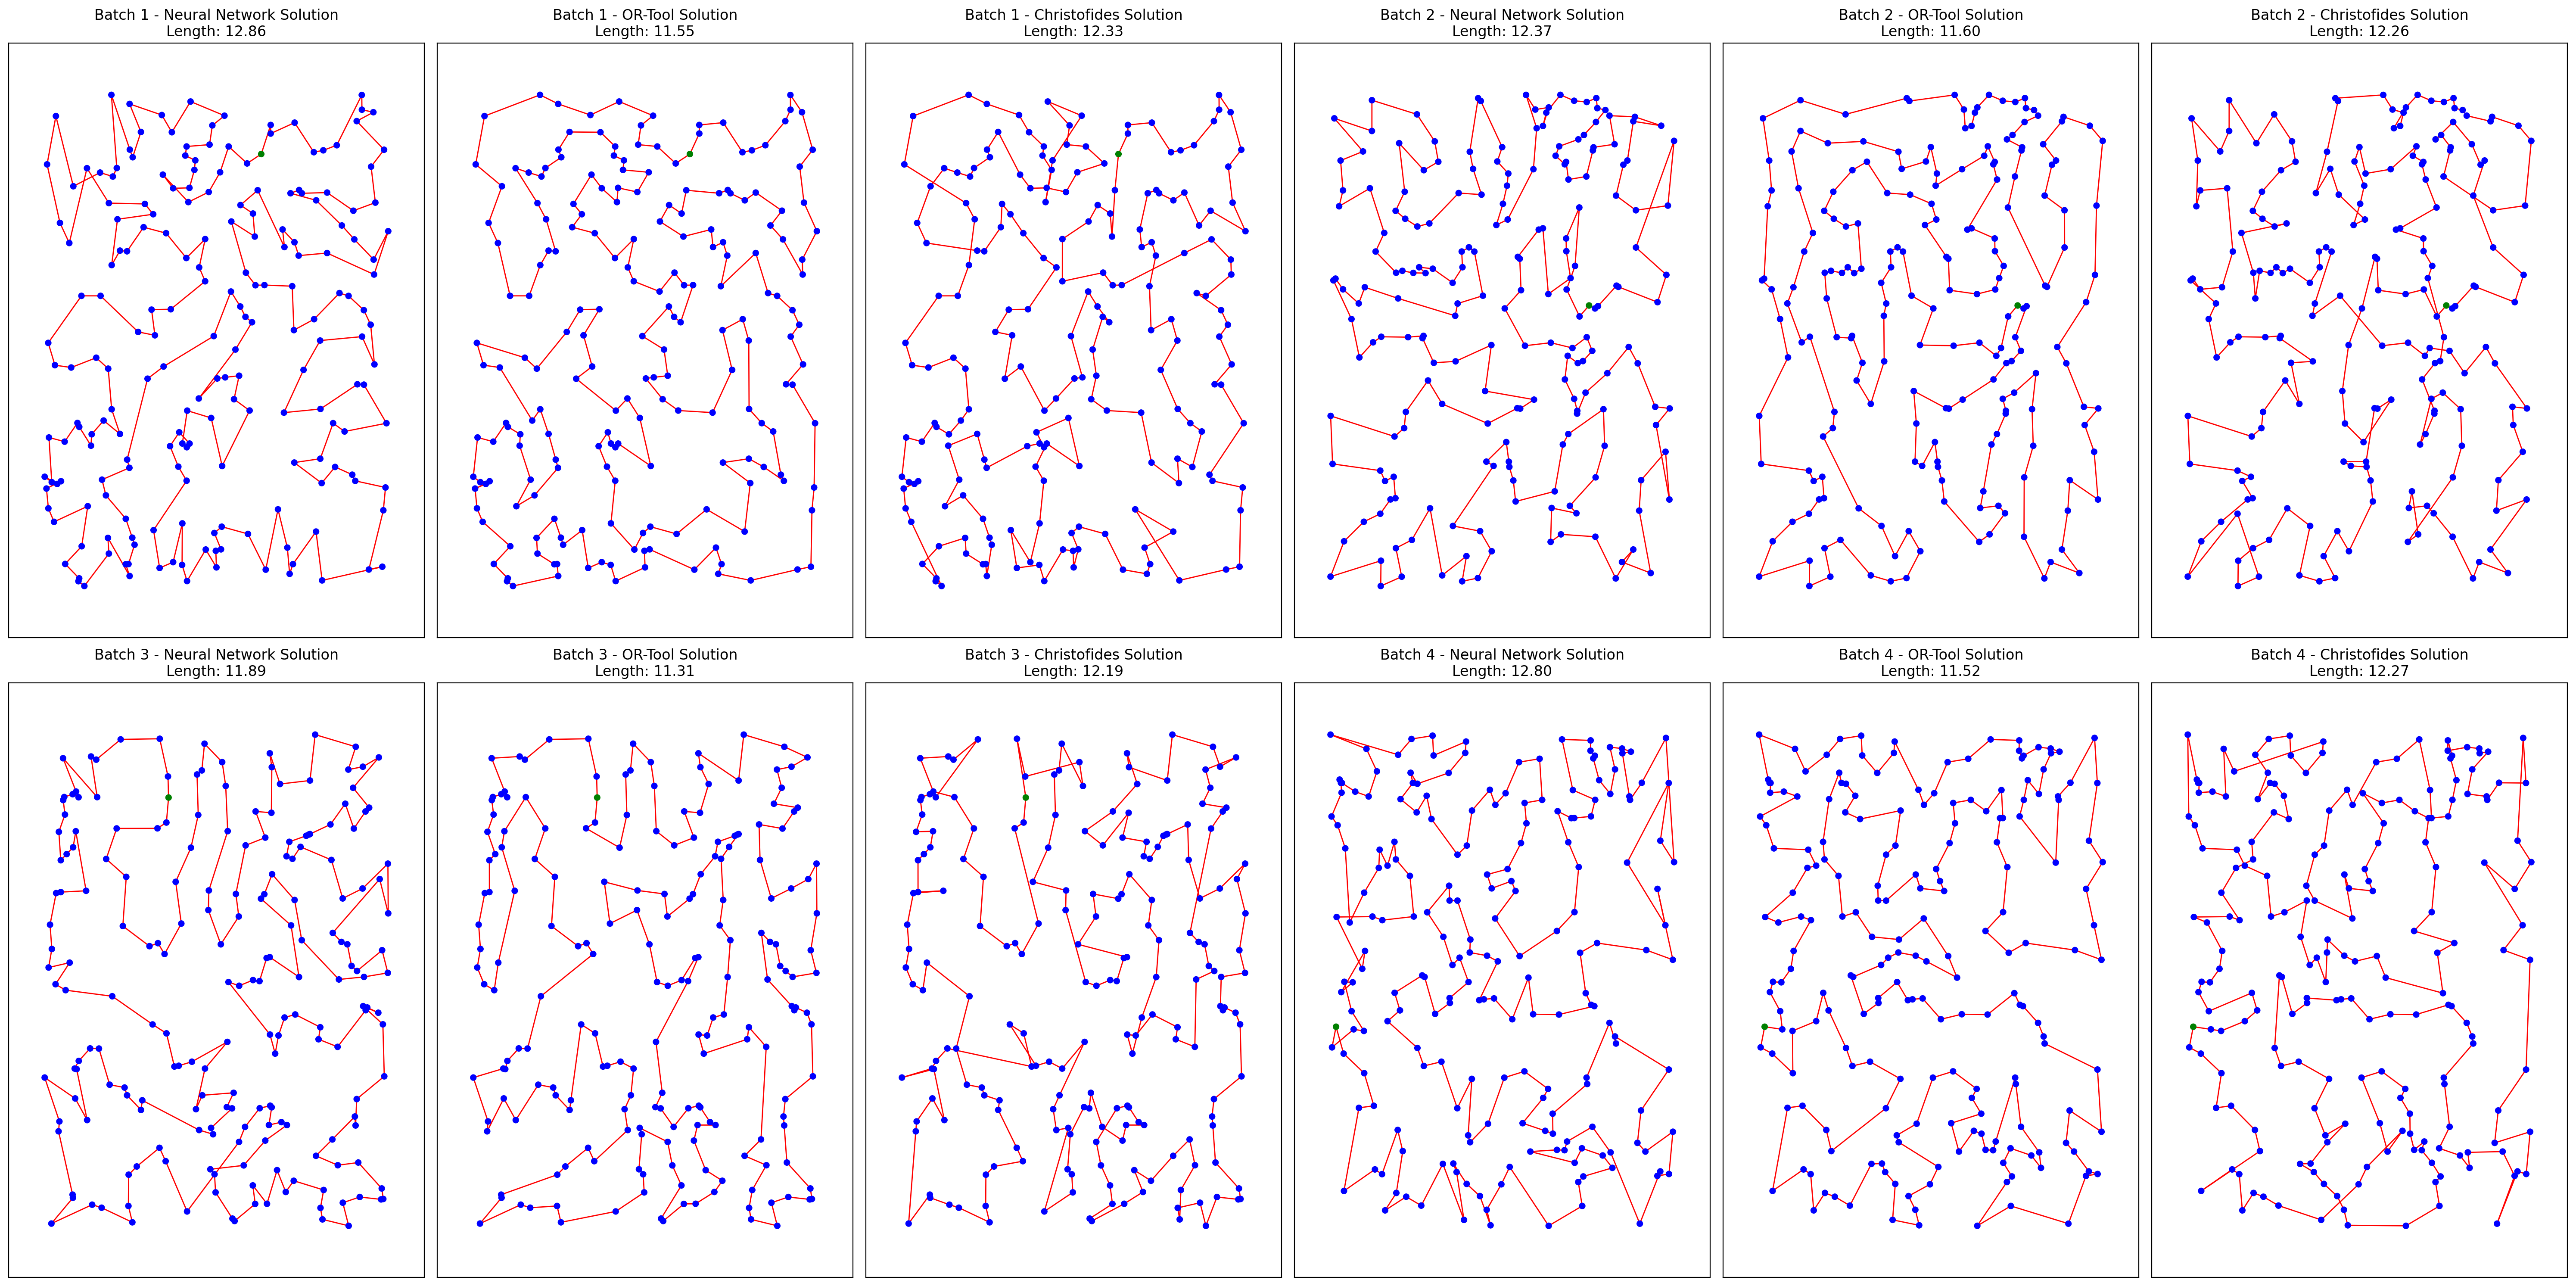

In [91]:
plot_combined_tsp_and_batches(
    x_coord_nn=nodes_tensor,
    x_path_nn=tours_beamsearch,
    x_coord_or=nodes_tensor,
    x_path_or=tour_tensor,
    x_coord_christofides=nodes_tensor,
    x_path_christofides=tours_christofides,
    plot_ortool=True,
    plot_dist_pair=False
)